In [1]:
"""
python 3.7
This file contains the code which implements k-nn classifier performance evaluation, 
including PCA-based dimentionality reduction of the embedding space.
The conclusions from these experiemnts were as follows:
    - k = 4 is the best parameter which improves classification accuracy by 0.5-1%.
    - PCA compression of the embeddings does not imporve accuracy.
Based on this data, a classification threshold of 0.9 - 0.95 is advised.
A better classifier, trained on top of the embeddings is compared with k-nn approach in "face_recognition_and_classification_on_top"
The code assumes that 128-length embeddings are extracted.
"""

from collections import defaultdict, Counter
import glob
import pickle
import numpy as np
from sklearn.metrics import f1_score, fbeta_score, precision_recall_fscore_support, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import scipy
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def load_embeddings(path, names=None):
    embeddings = []
    for user_embedding in glob.glob(path):
        if names:
            found_names = [name in user_embedding for name in names]
            if not any(found_names):
                continue
        with open(user_embedding, 'rb') as embed_file:
            user_info = pickle.load(embed_file, encoding='latin1')
            for user in user_info:
                embeddings.append(user)
    return embeddings

In [3]:
def distance(e1, e2):
    return np.min(np.linalg.norm(np.subtract(np.array(e1), np.array(e2)), axis=1))  # Euclidian distance
    #return np.matmul(np.array(e1), np.array(e2).transpose())[0][0]  # Cosine similarity

In [4]:
def calculate_distance(embeddings):
    # place a large value on diagonal to avoid matching with itself
    distances = [[10] * len(embeddings) for _ in range(len(embeddings))]
    classes = []
    for i, emb1 in enumerate(embeddings):
        classes.append(emb1["name"])
        for j, emb2 in enumerate(embeddings[i + 1:]):
            distances[i][i + 1 + j] = distances[i + 1 + j][i] = distance(emb1["embedding"], emb2["embedding"])
    classes = np.array(classes)
    distances = np.array(distances)
    datapoints_per_user = Counter(classes)
    return distances, classes

In [5]:
def recognize(embeddings, threshold):
    true = []
    pred = []
    for i, emb1 in enumerate(embeddings):
        for emb2 in embeddings[i + 1:]:
            dist = distance(emb1["embedding"], emb2["embedding"])
            if dist < threshold:
                pred.append(1)
            else:
                pred.append(0)
            if emb1["name"] == emb2["name"]:
                true.append(1)
            else:
                true.append(0)
    return true, pred

In [6]:
def get_users(embeddings):
    users = set()
    for emb in embeddings:
        if emb["name"] not in users:
            users.add(emb["name"])
    return list(users)

In [7]:
def binary_search(array, value):
    left = 0
    right = len(array) - 1
    while left < right - 1:
        center = (left + right) // 2
        if array[center] < value:
            left = center
        else:
            right = center
    return left

In [8]:
def calc_confusion_matrix(th, distances, classes, users, top_n=1):
    cm = [[0] * len(users) for _ in range(len(users))]
    for i, dist_to_i in enumerate(distances):      
        min_distance_top_n_idxs = np.argpartition(dist_to_i, top_n)[:top_n]
        top_n_names = classes[min_distance_top_n_idxs]
        top_n_counts = Counter(top_n_names)
        highest_frequency = max(top_n_counts.values())
        most_frequent_names = {name for name, max_counts in top_n_counts.items() if max_counts == highest_frequency}
        if len(most_frequent_names) > 1:
            # when there are several winners (several faces with the same number of counts),
            # select the name with the smallest average distance
            name_dist = defaultdict(float)
            for top_n_idx, top_n_name in enumerate(top_n_names):
                if top_n_name in most_frequent_names:
                    name_dist[top_n_name] += dist_to_i[min_distance_top_n_idxs[top_n_idx]]
            best_name, best_distance = min(name_dist.items(), key=lambda x: x[1])
            best_distance /= highest_frequency
        else:
            # when there is a single winner, select the smallest distance as best_distance
            best_name = most_frequent_names.pop()
            best_name_idx = min_distance_top_n_idxs[top_n_names == best_name][0]
            best_distance = dist_to_i[best_name_idx]

        if best_distance < th:
            idx1 = users.index(classes[i])
            idx2 = users.index(best_name)
            cm[idx1][idx2] += 1
    return np.array(cm)

In [9]:
def calc_false_recognitions(th, distances, classes, top_n=1):
    """
    This function calculates the number of times the embedding of a user was recognised wrongly in case the user is not registered.
    """
    false_recognitions = defaultdict(int)
    for i, dist_to_i in enumerate(distances):
        user = classes[i]
        # mask all distances that belong to this user
        dist_to_i = np.array(dist_to_i)
        masked_dist = dist_to_i[classes != user]
        
        min_k_dist_among_other_users = np.argpartition(masked_dist, top_n)[:top_n]
        min_dist_among_other_users = np.mean(masked_dist[min_k_dist_among_other_users])
 
        if min_dist_among_other_users < th:
            false_recognitions[user] += 1
    false_recognition_rate = sum(false_recognitions.values()) / len(classes)
    return false_recognition_rate

In [10]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
def statistics(cm, total):
    tp = np.trace(cm)
    total_recognized = np.sum(cm)
    precision = tp / total_recognized
    false_positive_rate = (total_recognized - tp)/total_recognized
    recall = tp / total
    return precision, recall, false_positive_rate

In [12]:
def do_pca(x, out_dim):
    mean = np.mean(x, axis=0)
    std = np.ones_like(mean)#  np.std(x, axis=0)
    x = (x - mean) / std
    cov = np.matmul(x.transpose(), x) / (x.shape[0] - 1)
    u, s, v = scipy.linalg.svd(cov)
    w = u[:, :out_dim]  # take first k columns
    return mean, std, w

In [13]:
def pca_error(original_x, x, mean, std, w):
    # backproject x
    hat_x = np.matmul(x, w.transpose()) * std + mean
    return np.linalg.norm(original_x - hat_x)

In [14]:
testing_embeddings = load_embeddings("face_embeddings/*.emb")
#testing_embeddings = load_embeddings("face_embeddings/*.emb", names={"person1", "person2"})  # these are Pascual and Priya
#testing_embeddings = load_embeddings("face_embeddings/*.emb", names={"ivan", "shubham"})
users = get_users(testing_embeddings)
print(users)

['shubham', 'amanosan', 'ivan', 'uedasan', 'person1', 'person2']


In [15]:
# preparation for PCA
# to avoid training/testing bias, I will use another datasets for calculating the projecton matrix
training_embeddings = load_embeddings("face_embeddings/*.emb", names={"ivan", "shubham"})
training_x = []
for emb in training_embeddings:
    training_x.append(emb["embedding"][0])
training_x = np.array(training_x)

In [16]:
# Homemade PCA
mean, std, w = do_pca(training_x, out_dim=4)

# PCA: error on validation dataset
projected_x = np.matmul((training_x - mean) / std,  w)
error = pca_error(training_x, projected_x, mean, std, w)
print(f"PCA error on validation dataset: {error}")

# PCA: apply to test data
pca_embeddings = []
for i, emb in enumerate(testing_embeddings):
    pca_embeddings.append({
        "name": emb["name"],
        "embedding": np.matmul((emb["embedding"] - mean) / std,  w),
    })
print(pca_embeddings[i]["embedding"][0, :4])

PCA error on validation dataset: 8.204917907714844
[-0.0858748   0.08004533 -0.15184563 -0.01580379]


In [17]:
# Alternative PCA
pca = PCA(16)
pca.fit(training_x)
pca_embeddings = []
for i, emb in enumerate(testing_embeddings):
    pca_embeddings.append({
        "name": emb["name"],
        "embedding": pca.transform(emb["embedding"]),
    })
print(pca_embeddings[i]["embedding"][0, :4])

[ 0.08587467 -0.08004522  0.15184551  0.01580448]


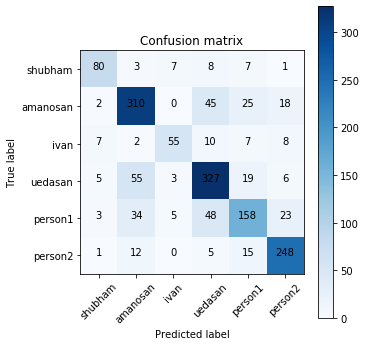

In [18]:
# Test if the reduced embeddings have better discriminative power
# results do not seem to be better then 128-dim embeddings
distances, classes = calculate_distance(pca_embeddings)
cm = calc_confusion_matrix(0.95, distances, classes, users, top_n=1)
plot_confusion_matrix(cm, users)

In [19]:
embeddings = testing_embeddings
distances, classes = calculate_distance(testing_embeddings)

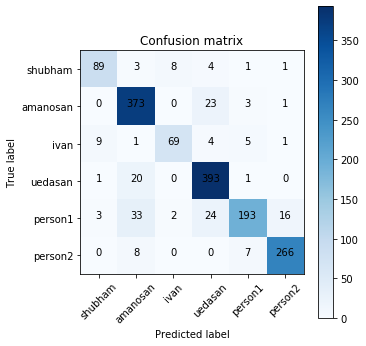

In [20]:
cm = calc_confusion_matrix(0.95, distances, classes, users, top_n=1)
plot_confusion_matrix(cm, users)

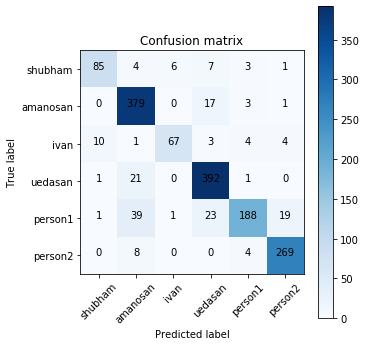

In [21]:
cm = calc_confusion_matrix(0.95, distances, classes, users, top_n=3)
plot_confusion_matrix(cm, users)

In [22]:
top_ns = [1, 2, 3, 4, 5]
thresholds = np.linspace(0.3, 1.4, 50)
total = len(embeddings) - 1
stat = defaultdict(lambda: defaultdict(list))
for top_n in top_ns:
    for th in thresholds:
        cm = calc_confusion_matrix(th, distances, classes, users, top_n=top_n)
        precision, recall, false_positive_rate = statistics(cm, total)
        stat["precision"][f"top_{top_n}"].append(precision)
        stat["recall"][f"top_{top_n}"].append(recall)
        stat["false_positive_rate"][f"top_{top_n}"].append(false_positive_rate)
        false_recognition_rate = calc_false_recognitions(th, distances, classes, top_n=top_n)
        stat["false_recognition_rate"][f"top_{top_n}"].append(false_recognition_rate)

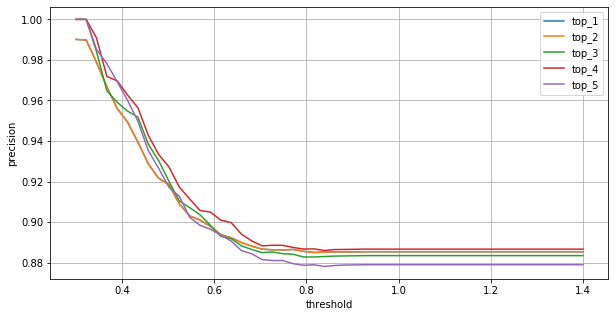

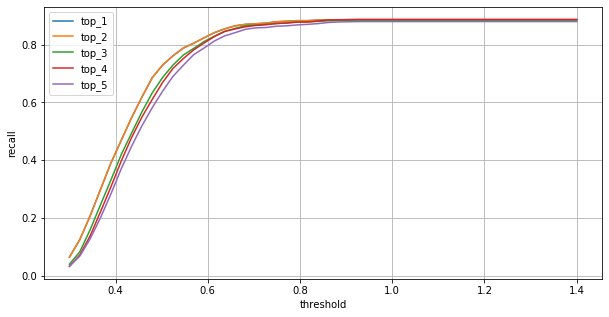

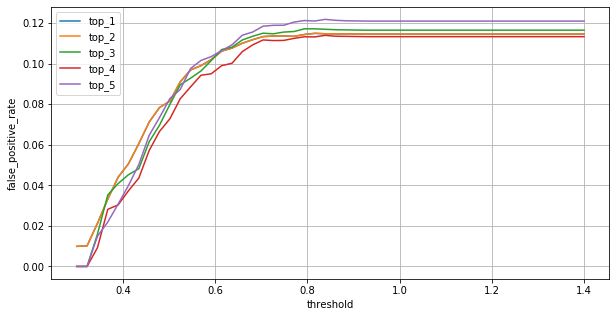

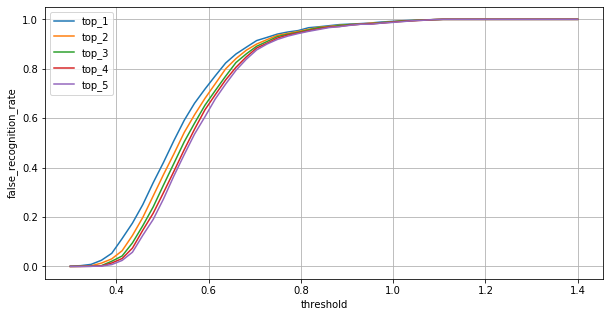

In [23]:
for metric in stat:
    for top_n in stat[metric]:
        plt.plot(thresholds, stat[metric][top_n], label=top_n)
    plt.legend()
    plt.xlabel("threshold")
    plt.ylabel(metric)
    plt.grid()
    plt.show()

In [24]:
def print_threshold_selection_results(th, thresholds, stat):
    idx = binary_search(thresholds, th)
    print(f"threshold {thresholds[idx]}")
    pr, re, fpr, frr = stat["precision"][idx], stat["recall"][idx], stat["false_positive_rate"][idx], stat["false_recognition_rate"][idx]
    print(f"  precision: {pr}")
    print(f"  recall: {re}")
    print(f"  false positive rate: {fpr}")
    print(f"  false recognition rate: {frr}")
    print()

In [25]:
print_threshold_selection_results(0.95, thresholds, stat)
print_threshold_selection_results(0.85, thresholds, stat)
print_threshold_selection_results(0.7, thresholds, stat)
print_threshold_selection_results(0.64, thresholds, stat)
print_threshold_selection_results(0.6, thresholds, stat)

threshold 0.9285714285714286
  precision: []
  recall: []
  false positive rate: []
  false recognition rate: []

threshold 0.8387755102040817
  precision: []
  recall: []
  false positive rate: []
  false recognition rate: []

threshold 0.6816326530612244
  precision: []
  recall: []
  false positive rate: []
  false recognition rate: []

threshold 0.636734693877551
  precision: []
  recall: []
  false positive rate: []
  false recognition rate: []

threshold 0.5918367346938775
  precision: []
  recall: []
  false positive rate: []
  false recognition rate: []

